Load documentos with

In [1]:
!pip install sentence-transformers
!pip install -q langchain
!pip install -q faiss-cpu
!pip install -q pypdf
!pip install openai
!pip install python-dotenv
!pip install tqdm
!pip install -U langchain-community
!pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.1 MB/s eta 0:00:00


In [ ]:
!pip install langchain-huggingface

In [ ]:
cd '/content/drive/MyDrive/Courses/AI/Lecture14'

/content/drive/MyDrive/Courses/AI/Lecture14


In [ ]:
from dotenv import load_dotenv
from tqdm.notebook import tqdm
import os

In [ ]:
load_dotenv('api_keys.env')
api_key = os.getenv('OPENAI_API_KEY')

In [ ]:
import requests

with open('documents-with-ids.json', 'rt') as f_in:
    documents = json.load(f_in)

In [ ]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

Load ground truth

In [ ]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [ ]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [ ]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

Index data

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
documents[0].keys()

dict_keys(['text', 'section', 'question', 'course', 'id'])

In [ ]:
from uuid import uuid4
from langchain_core.documents import Document

docs = []
idx = []

for doc in documents:
    document = Document(page_content = doc["text"] + doc["question"], metadata={'id': doc['id'], "section": doc["section"], "course": doc["course"]})
    idx.append(doc["id"])
    docs.append(document)


In [ ]:
from langchain.vectorstores import FAISS

In [ ]:
# Create the FAISS index with all embeddings and metadata in batch
db = FAISS.from_documents(docs, hf)

In [2]:
# Optional: Save the index for later use
db.save_local("my_faiss_index")

NameError: name 'db' is not defined

In [ ]:
#Similarity search
#https://python.langchain.com/v0.2/docs/integrations/vectorstores/faiss/
results = db.similarity_search(
    "Are sessions recorded if I miss one?",
    filter={"course": "machine-learning-zoomcamp"},
)

for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.What if I miss a session? [{'id': '5170565b', 'section': 'General course-related questions', 'course': 'machine-learning-zoomcamp'}]
* The course videos are pre-recorded, you can start watching the course right now.
We will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.
You can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.Is it going to be live? When? [{'id': '39fda9f0', 'section': 'General course-related questions', 'course': 'machine-learning-zoomcamp'}]
* We won’t re-record the course videos. The focus of the course and the skills we want to teach remained the same, and the videos are still up-to-date.
If you haven’t taken part in the prev

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
retriever = db.as_retriever()

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

In [ ]:
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: filler question 
Context: filler context 
Answer:


In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

idx = 10

course = ground_truth[10]["course"]

retriever = db.as_retriever(search_kwargs={"filter": {"course": course}})

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

response = rag_chain.invoke(ground_truth[idx]["question"])
print(response)

Yes, all sessions are recorded, so you won't miss anything if you happen to miss a session. You can catch up by watching the recorded videos, which are available in the course playlist on YouTube. Additionally, office hours are also recorded, allowing you to review any questions and answers discussed during those sessions.


In [ ]:
ground_truth[idx]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [ ]:
doc_idx[ground_truth[idx]["document"]]["text"]

'E'

Cosine similarity metric

In [ ]:
from langchain.evaluation import load_evaluator

hf_evaluator = load_evaluator("pairwise_embedding_distance", embeddings=hf)

In [ ]:
hf_evaluator.evaluate_string_pairs(prediction=response,prediction_b=doc_idx[ground_truth[idx]["document"]]["text"])

{'score': 0.3284273616858291}

In [ ]:
from typing import Dict, Optional
from functools import partial

In [ ]:
def format_docs(docs):
    """Format documents into a single string."""
    return "\n\n".join(doc.page_content for doc in docs)

def get_context(query: str, db, filters: Dict = None):
    """
    Get context with dynamic filters for each query.

    Args:
        query: The question string
        db: Vector database
        filters: Dictionary of filters to apply
    """
    # Create retriever with current filters
    retriever = db.as_retriever(
        search_kwargs={"filter": filters if filters else None}
    )

    # Get and format documents
    docs = retriever.invoke(query)
    return format_docs(docs)

def create_dynamic_rag_chain(db, llm, prompt):
    """
    Create a RAG chain that accepts dynamic filters per query.

    Args:
        db: Vector database
        llm: Language model
        prompt: Prompt template

    Returns:
        Callable RAG chain that accepts query and filters
    """
    # Partial function for get_context with db parameter filled
    context_getter = partial(get_context, db=db)

    # Build the base chain
    base_chain = (
        prompt
        | llm
        | StrOutputParser()
    )

    def rag_chain(query: str, filters: Optional[Dict] = None):
        """
        Run the RAG chain with dynamic filters.

        Args:
            query: The question string
            filters: Optional dictionary of filters (including course)
        """
        # Get context with current filters
        context = context_getter(query=query, filters=filters)

        # Run the chain
        return base_chain.invoke({"context": context, "question": query})

    return rag_chain


In [ ]:
# Create the dynamic RAG chain
dynamic_rag = create_dynamic_rag_chain(db=db, llm=llm, prompt=prompt)

idx = 10
course1 = ground_truth[idx]["course"]
question1 = ground_truth[idx]["question"]
# Use with different courses/filters for each query
response1 = dynamic_rag(
    query=question1,
    filters={"course": course}
)

idx = 20
course2 = ground_truth[idx]["course"]
question2 = ground_truth[idx]["question"]
response2 = dynamic_rag(
    query=question2,
    filters={"course": course}
)

print(question1)
print(response1)
print(question2)
print(response2)

Are sessions recorded if I miss one?
Yes, sessions are recorded, so you won't miss anything if you can't attend. You can access both the pre-recorded course videos and the recorded office hours on the course playlist on YouTube. This allows you to catch up at your convenience.
Is prior knowledge in math necessary for this course?
Prior knowledge in math is helpful but not strictly necessary for this course. The focus is on practical application rather than deep theoretical understanding, and the course will cover linear algebra at an intuitive level. Students are encouraged to engage with the community for support if they have questions.


In [ ]:
answers = {}

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    answer_llm = dynamic_rag(
    query=rec["question"],
    filters={"course": rec["course"]}
    )
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

  0%|          | 0/1830 [00:00<?, ?it/s]

In [ ]:
results_gpt4o_mini = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o_mini[i] = val.copy()
    results_gpt4o_mini[i].update(ground_truth[i])

In [ ]:
import pandas as pd

In [ ]:
df_gpt4o_mini = pd.DataFrame(results_gpt4o_mini)

In [ ]:
df_gpt4o_mini.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,I don't know.,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"Yes, the course has a GitHub repository for th...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [ ]:
similarity = []

for record in tqdm(results_gpt4o_mini):
    sim = hf_evaluator.evaluate_string_pairs(prediction=record['answer_llm'],prediction_b=record['answer_orig'])
    similarity.append(sim['score'])

  0%|          | 0/1830 [00:00<?, ?it/s]

In [ ]:
df_gpt4o_mini['cosine'] = similarity
df_gpt4o_mini['cosine'].describe()



,cosine
count,1830.000000
mean,0.339824
std,0.222405
min,0.026575
25%,0.186785
50%,0.277139
75%,0.433898
max,1.155226


In [ ]:
sim

{'score': 0.5792845512725673}

In [ ]:
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-66-5d0029fda60b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')


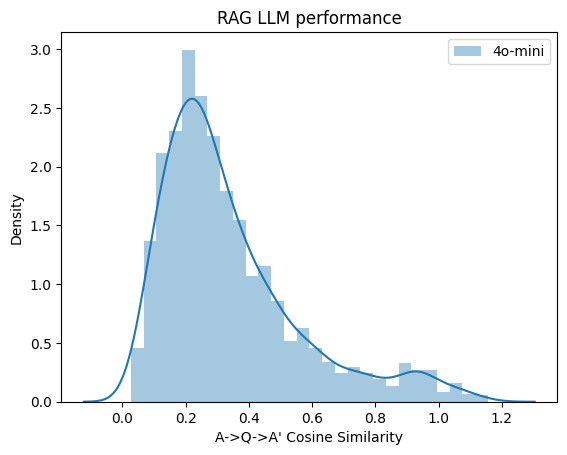

In [ ]:
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

In [ ]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [ ]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [ ]:
samples = df_sample.to_dict(orient='records')

In [ ]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows: \n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```\n\nThis function returns precision, recall, F-score, and support based on the true and predicted values.',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.15162136694744488}

In [ ]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows: 

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val

In [ ]:
answer = llm.invoke(prompt, model='gpt-4o-mini')

In [ ]:
answer

AIMessage(content='{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly addresses the question about the syntax for using `precision_recall_fscore_support` in Python. It includes the exact code snippet provided in the original answer and explains what the function returns, which aligns well with the original content."\n}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 329, 'total_tokens': 395, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-7ac428b8-13e7-4d6c-859c-404f242e709b-0', usage_metadata={'input_tokens': 329, 'output_tokens': 66, 'total_tokens': 395, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [ ]:
import json

In [ ]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
evaluations[0]

AIMessage(content='{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly addresses the original question about the syntax for using `precision_recall_fscore_support` in Python. It includes the correct code snippet as provided in the original answer and adds a brief explanation about the return values of the function, which enhances the context without deviating from the core information."\n}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 329, 'total_tokens': 407, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-13a5f1b4-8904-4acb-81d8-85c779918337-0', usage_metadata={'input_tokens': 329, 'output_tokens': 78, 'total_tokens': 407, 'input_token_details': {'cache_read': 0},

In [ ]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval.content)
    json_evaluations.append(json_eval)

In [ ]:
df_evaluations = pd.DataFrame(json_evaluations)

In [ ]:
df_evaluations.Relevance.value_counts()

,count
Relevance,
RELEVANT,111
PARTLY_RELEVANT,26
NON_RELEVANT,13


In [ ]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer addresses a different iss...
11,NON_RELEVANT,The generated answer addresses a different iss...
41,NON_RELEVANT,The generated answer discusses how to set up a...
52,NON_RELEVANT,The generated answer does not address the reco...
67,NON_RELEVANT,The generated answer does not address the orig...
71,NON_RELEVANT,The generated answer does not address the cont...
81,NON_RELEVANT,The generated answer discusses the number of p...
84,NON_RELEVANT,The generated answer does not address the ques...
93,NON_RELEVANT,The generated answer does not address the orig...
116,NON_RELEVANT,The original answer discusses access to a link...


In [ ]:
samples[4]

{'answer_llm': "The pip version error in this week's serverless deep learning section may be caused by an incorrect setting of the environment variable LANG, which is not set in the bash profile. Additionally, there could be compatibility issues between the versions of Flask and Werkzeug being used. A quick fix involves adjusting the versions in the Pipfile or the environment settings.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.7.0-cp39-cp39-linux_x86_64.whl\nPastor Soto',
 'document': '42c09143',
 'question': "What might be the cause o